> Created on Thu Feb 18 15:34:40 2021 @author: richiebao workshop-LA-UP_IIT

In [ ]:
import utils

In [5]:
poi_classificationName={
        "美食 ":"delicacy",
        #"酒店 ":"hotel",
        #"购物 ":"shopping",
        #"生活服务":"lifeService",
        #"丽人 ":"beauty",
        #"旅游景点":"spot",
        #"休闲娱乐":"entertainment",
        #"运动健身":"sports",
        #"教育培训":"education",
        #"文化传媒":"media",
        #"医疗 ":"medicalTreatment",
        #"汽车服务":"carService",
        #"交通设施":"trafficFacilities",
        #"金融":"finance",
        #"房地产":"realEstate",
        #"公司企业":"corporation",
        #"政府机构":"government"
        }

In [ ]:
poi_config_para={
    'data_path':'./data/poi_batchCrawler/', #配置数据存储位置
    'bound_coordinate':{'leftBottom':[118.700068,32.00979],'rightTop':[118.818932,32.086915]}, #百度地图坐标拾取系统 http://api.map.baidu.com/lbsapi/getpoint/index.html
    'page_num_range':range(20),
    'partition':3, #3
    'page_size':'20', #20
    'scope':2,
    'ak':'uqRcWhrQ6h0pAaSdxYn73GMWgd5uNrRX',
}

In [ ]:
def baiduPOI_batchCrawler(poi_config_para):
    import os
    import utils
    '''function-百度地图开放平台POI数据批量爬取，需要调用单个分类POI爬取函数baiduPOI_dataCrawler(query_dic,bound_coordinate,partition,page_num_range,poi_fn_list=False)'''
    for idx,(poi_ClassiName,poi_classMapping) in enumerate(poi_classificationName.items()):
        print(str(idx)+"_"+poi_ClassiName)
        poi_subFileName="poi_"+str(idx)+"_"+poi_classMapping
        data_path=poi_config_para['data_path']
        poi_fn_csv=os.path.join(data_path,poi_subFileName+'.csv')
        poi_fn_json=os.path.join(data_path,poi_subFileName+'.json')
        
        query_dic={
            'query':poi_ClassiName,
            'page_size':poi_config_para['page_size'],
            'scope':poi_config_para['scope'],
            'ak':poi_config_para['ak']                        
        }
        bound_coordinate=poi_config_para['bound_coordinate']
        partition=poi_config_para['partition']
        page_num_range=poi_config_para['page_num_range']
        #调用单个分类POI爬取函数
        utils.baiduPOI_dataCrawler(query_dic,bound_coordinate,partition,page_num_range,poi_fn_list=[poi_fn_csv,poi_fn_json])  
        
baiduPOI_batchCrawler(poi_config_para)

In [1]:
def filePath_extraction(dirpath,fileType):
    import os
    '''funciton-以所在文件夹路径为键，值为包含该文件夹下所有文件名的列表。文件类型可以自行定义 '''
    filePath_Info={}
    i=0
    for dirpath,dirNames,fileNames in os.walk(dirpath): #os.walk()遍历目录，使用help(os.walk)查看返回值解释
       i+=1
       if fileNames: #仅当文件夹中有文件时才提取
           tempList=[f for f in fileNames if f.split('.')[-1] in fileType]
           if tempList: #剔除文件名列表为空的情况,即文件夹下存在不为指定文件类型的文件时，上一步列表会返回空列表[]
               filePath_Info.setdefault(dirpath,tempList)
    return filePath_Info

dirpath='./data/poi_batchCrawler/'
fileType=["csv"]
poi_paths=filePath_extraction(dirpath,fileType)
print(poi_paths)

{'./data/poi_batchCrawler/': ['poi_0_delicacy.csv', 'poi_10_medicalTreatment.csv', 'poi_11_carService.csv', 'poi_12_trafficFacilities.csv', 'poi_13_finance.csv', 'poi_14_realEstate.csv', 'poi_15_corporation.csv', 'poi_16_government.csv', 'poi_1_hotel.csv', 'poi_2_shopping.csv', 'poi_3_lifeService.csv', 'poi_4_beauty.csv', 'poi_5_spot.csv', 'poi_6_entertainment.csv', 'poi_7_sports.csv', 'poi_8_education.csv', 'poi_9_media.csv']}


In [11]:
fields_extraction=['name','location_lat', 'location_lng','detail_info_tag','detail_info_overall_rating', 'detail_info_price'] #配置需要提取的字段，即列（columns）
save_path={'geojson':'./data/poiAll_gpd.geojson','shp':'./data/poiAll_gpd.shp','pkl':'./data/poiAll_gpd.pkl'} #分别存储为GeoJSON、Shapefile和pickle三种数据格式
def poi_csv2GeoDF_batch(poi_paths,fields_extraction,save_path):
    import os,pathlib
    import utils
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Point
    from pyproj.crs import CRS
    '''funciton-.csv格式POI数据批量转换为GeoDataFrame，需要调用转换.csv格式的POI数据为pandas的DataFrame函数csv2df(poi_fn_csv)'''
    #循环读取与转换poi的.csv文件为pandas的DataFrame数据格式
    poi_df_dic={}
    i=0
    for key in poi_paths:
        for val in poi_paths[key]:
            poi_csvPath=os.path.join(key,val)
            poi_df=utils.csv2df(poi_csvPath) #注释掉了了csv2df()函数内部的print("%s data type is not converted..."%(col))语句，以pass替代，减少提示内容，避免干扰
            print(val)
            poi_df_path=pathlib.Path(val)
            poi_df_dic[poi_df_path.stem]=poi_df
            
            #if i==2:break
            i+=1
    poi_df_concat=pd.concat(poi_df_dic.values(),keys=poi_df_dic.keys(),sort=True)
    #print(poi_df_concat.loc[['poi_0_delicacy'],:]) #提取index为 'poi_0_delicacy'的行，验证结果
    poi_fieldsExtraction=poi_df_concat.loc[:,fields_extraction]
    poi_geoDF=poi_fieldsExtraction.copy(deep=True)
    poi_geoDF['geometry']=poi_geoDF.apply(lambda row:Point(row.location_lng,row.location_lat),axis=1) 
    crs_4326=CRS('epsg:4326') #配置坐标系统，参考：https://spatialreference.org/        
    poiAll_gpd=gpd.GeoDataFrame(poi_geoDF,crs=crs_4326)     
    
    poiAll_gpd.to_pickle(save_path['pkl'])
    #print(poiAll_gpd)
    #poiAll_gpd.to_file(save_path['geojson'],driver='GeoJSON')
    
    poiAll_gpd2shp=poiAll_gpd.reset_index() #不指定level参数，例如Level=0，会把多重索引中的所有索引转换为列
    poiAll_gpd2shp.rename(columns={
        'location_lat':'lat', 'location_lng':'lng',
        'detail_info_tag':'tag','detail_info_overall_rating':'rating', 'detail_info_price':'price'},inplace=True)
    poiAll_gpd2shp.to_file(save_path['shp'],encoding='utf-8')
        
    return poiAll_gpd
            
poi_gpd=poi_csv2GeoDF_batch(poi_paths,fields_extraction,save_path)

__________________________________________________
.csv to DataFrame is completed!
poi_0_delicacy.csv
__________________________________________________
.csv to DataFrame is completed!
poi_10_medicalTreatment.csv
__________________________________________________
.csv to DataFrame is completed!
poi_11_carService.csv
__________________________________________________
.csv to DataFrame is completed!
poi_12_trafficFacilities.csv
__________________________________________________
.csv to DataFrame is completed!
poi_13_finance.csv
__________________________________________________
.csv to DataFrame is completed!
poi_14_realEstate.csv
__________________________________________________
.csv to DataFrame is completed!
poi_15_corporation.csv
__________________________________________________
.csv to DataFrame is completed!
poi_16_government.csv
__________________________________________________
.csv to DataFrame is completed!
poi_1_hotel.csv
__________________________________________________
.c

<AxesSubplot:>

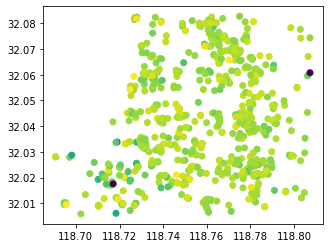

In [12]:
poi_gpd.loc[['poi_0_delicacy'],:].plot(column='detail_info_overall_rating') #提取index为'poi_0_delicacy'的行查看结果

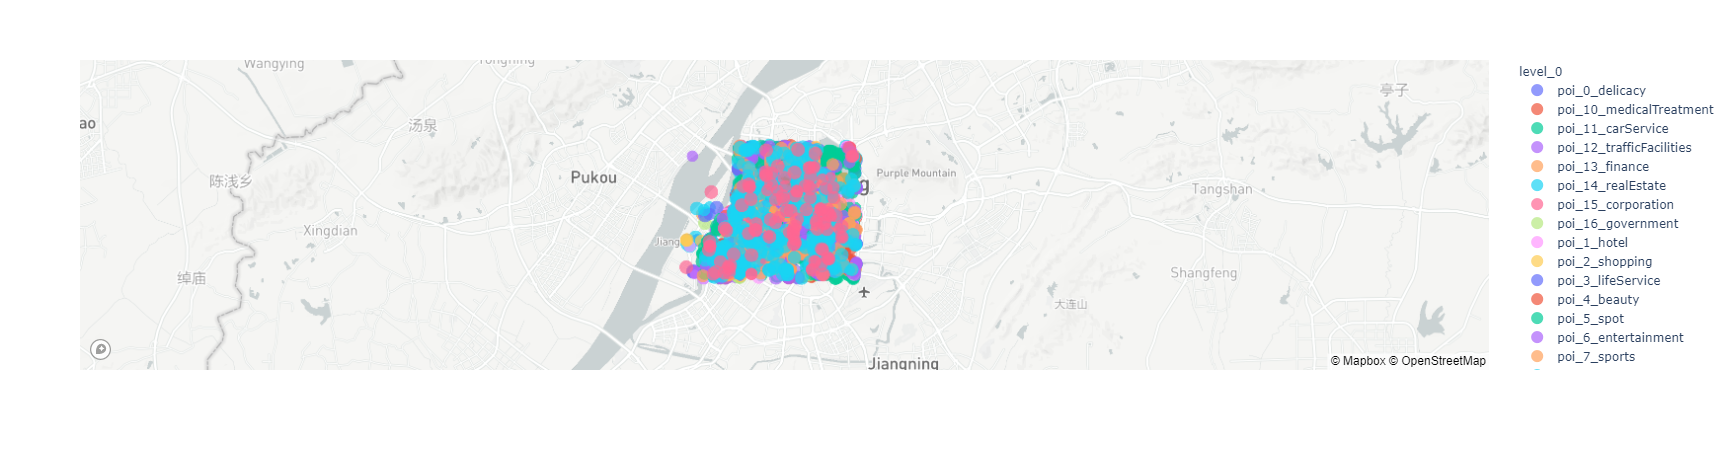

In [4]:
import geopandas as gpd
poi_gpd=gpd.read_file('./data/poiAll_gpd.shp') #读取存储的.shp格式文件

import plotly.express as px
poi_gpd.rating=poi_gpd.rating.fillna(0) #pandas库的方法同样适用于geopandas库，例如对`nan`位置填充指定数值
mapbox_token='pk.eyJ1IjoicmljaGllYmFvIiwiYSI6ImNrYjB3N2NyMzBlMG8yc254dTRzNnMyeHMifQ.QT7MdjQKs9Y6OtaJaJAn0A'
px.set_mapbox_access_token(mapbox_token)
fig=px.scatter_mapbox(poi_gpd,lat=poi_gpd.lat, lon=poi_gpd.lng,color="level_0",size='rating',color_continuous_scale=px.colors.cyclical.IceFire, size_max=10, zoom=10,hover_data=['tag','name']) #亦可以选择列，通过size=""配置增加显示信息
fig.show()

In [2]:
poi_gpd

level_0  level_1            name        lat         lng  \
0      poi_0_delicacy        0       烟波渔港(梦都店)  32.017030  118.715871   
1      poi_0_delicacy        2      源江渔港(绿博园店)  32.025911  118.708387   
2      poi_0_delicacy        4          滨江花园酒店  32.021558  118.706405   
3      poi_0_delicacy        6  香阳楼大酒店(扬子江大道店)  32.005910  118.702291   
4      poi_0_delicacy        8     江南名灶(兴隆大街店)  32.020474  118.722079   
...               ...      ...             ...        ...         ...   
13035     poi_9_media     1622     上海英斯派广告有限公司  32.079896  118.768784   
13036     poi_9_media     1624  南京金霖小雅装饰工程有限公司  32.066636  118.780481   
13037     poi_9_media     1626         宴会和会议中心  32.063100  118.778330   
13038     poi_9_media     1628        玄武饭店-会议室  32.072872  118.778474   
13039     poi_9_media     1630          凤凰会展中心  32.070711  118.778606   

            tag  rating price                    geometry  
0        美食;中餐厅     3.7   196  POINT (118.71587 32.01703)  
1        美食;中餐厅     3.9   183  POINT (118.70839 32.02591)  
2        美食;中餐厅     4.1   337  POINT (118.70640 32.02156)  
3        美食;中餐厅     4.2   227  POINT (118.70229 32.00591)  
4        美食;中餐厅     4.5    91  POINT (118.72208 32.02047)  
...         ...     ...   ...                         ...  
13035   公司企业;公司     0.0  None  POINT (118.76878 32.07990)  
13036   公司企业;公司     0.0  None  POINT (118.78048 32.06664)  
13037  文化传媒;展览馆     0.0  None  POINT (118.77833 32.06310)  
13038  文化传媒;展览馆     0.0  None  POINT (118.77847 32.07287)  
13039  文化传媒;展览馆     0.0  None  POINT (118.77861 32.07071)  

[13040 rows x 9 columns]